<a href="https://colab.research.google.com/github/OwenHuels/data-science/blob/main/Owen_Unit8NotesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymc-bart
!pip install preliz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 5.9 MB/s eta 0:00:00


In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import preliz as pz
import seaborn as sns

# Unit 8: Bayesian Additive Regression Trees (BART)

Bayesian Additive Regression Trees (BART) can be thought of as a fast approximation of Gaussian Processes (GPs). The specific way BART models work has various limitations, quirks, and benefits; we'll dicuss them all in this unit.

We'll learn:
- what a decision tree is
- how BART models work, and their relationshipp to decision trees
- how to implement BART in PyMC
- Partial Dependence Plots (pdp)
- Individual Conditional Expecation plots (ice)
- variable importance (vi) plots

Let's get started.

## Theoretical Background: Trees and Forests



### Decision Trees

Think of decision trees as flow charts (the technical term is a graph), but with several restrictions.
- Each node can have only one 'parent' node, but many children.
-We'll focus on binary decision trees, where each node as one parent, and two or zero children
- There is a special node called the 'root' node, with no parents
- Each layer of the tree sorts the predictor values into subsets of the predicted values

All thos points are best illustrated with an example.

For our example, we'll use some data on octupus beaks, and try to use upper beak length (predictor) to predict total beak length (predictor).


In [3]:
from sklearn import tree

**Make sure to read my comments!**

In [4]:
#data on octupus beaks
octps = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/octopusbeakweight_nlin.csv')

In [5]:
#X is our predictor variable, upper beak measurment
X = octps["upBeak"].to_numpy().reshape(-1, 1)
#Y is the predicted variable, total beak weight
Y = octps["totWt"].to_numpy()

In [6]:
#fits a decision tree. This is analogous to running pm.sample,
#except it only finds the mean. Kinda like that, anyway.
dtree = tree.DecisionTreeRegressor(max_depth=2)
octtree = dtree.fit(X,Y)

#uses the fitted model to predict total weight for various
#unseen upper beark measurements
#This is analogous to a posterior predictive distribution,
#if we only found the posterior predictive mean...
#...kinda.
X_test = np.arange(75, 250, 1)[:, np.newaxis]
y = octtree.predict(X_test)

Below is the graph (flow chart-y) version of the decision tree.

[Text(0.5, 0.8333333333333334, 'x[0] <= 159.5\nsquared_error = 1880924.432\nsamples = 30\nvalue = 1927.633'),
 Text(0.25, 0.5, 'x[0] <= 125.5\nsquared_error = 1306456.64\nsamples = 25\nvalue = 1559.6'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, 'squared_error = 142494.025\nsamples = 9\nvalue = 787.444'),
 Text(0.375, 0.16666666666666666, 'squared_error = 1437160.434\nsamples = 16\nvalue = 1993.938'),
 Text(0.75, 0.5, 'x[0] <= 186.5\nsquared_error = 689807.36\nsamples = 5\nvalue = 3767.8'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, 'squared_error = 923203.556\nsamples = 3\nvalue = 4063.667'),
 Text(0.875, 0.16666666666666666, 'squared_error = 11449.0\nsamples = 2\nvalue = 3324.0')]

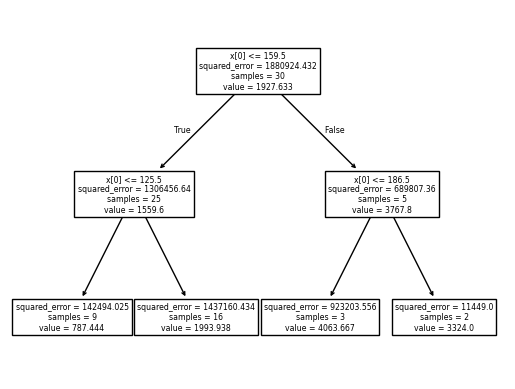

In [7]:
tree.plot_tree(octtree)

The below graph is similar to if I'd plot just the posterior predictive mean.

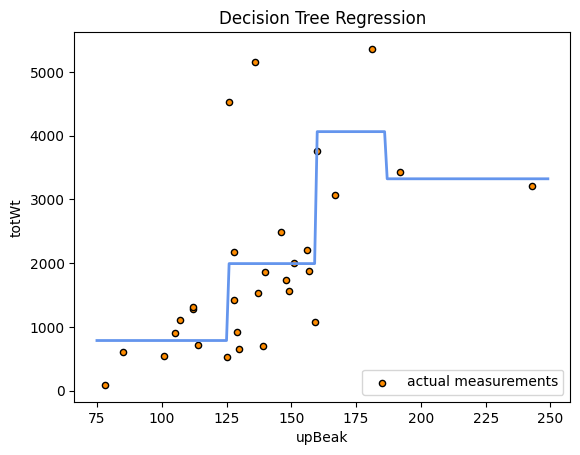

In [8]:
plt.figure()
plt.scatter(X, Y, s=20, edgecolor="black", c="darkorange", label="actual measurements")
plt.plot(X_test, y, color="cornflowerblue", linewidth=2)
plt.xlabel("upBeak")
plt.ylabel("totWt")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

**Task1**:

The graph (flow chart-y) version of the tree has four nodes with no children, often called 'leaf' nodes.

Each of those nodes something that says "value =", then a number.

What are those numbers, and what do they have to do with the psuedo-posterior predictive mean from the scatter plot?

Those are the predicted total beak lengths. These are where the horizontal lines are placed on our graph.

**Task2**:

There are three other nodes in the graph (flow chart-y) version of the decision tree.

These start with a text that reads "x[0] <=" followed by a number.

What do these numbers mean, and what do they have to do with the psuedo-posterior predictive mean from the scatter plot?

These are the vertical bar cutoffs between the different horizontal sections of our graph.

**Task3**:

There are two others numbers in each node: "squared error" and samples.

What do those mean?

Samples is the number of data points that fall in each box. Squared error is how the model knows where the best place to put each line is.

**Task4**:

Change max_depth to equal 5 in the above code, and the recreate both graphs.

What changes?

What did max_depth do?

In [9]:
#X is our predictor variable, upper beak measurment
X = octps["upBeak"].to_numpy().reshape(-1, 1)
#Y is the predicted variable, total beak weight
Y = octps["totWt"].to_numpy()

In [10]:
#fits a decision tree. This is analogous to running pm.sample,
#except it only finds the mean. Kinda like that, anyway.
dtree = tree.DecisionTreeRegressor(max_depth=5)
octtree = dtree.fit(X,Y)

#uses the fitted model to predict total weight for various
#unseen upper beark measurements
#This is analogous to a posterior predictive distribution,
#if we only found the posterior predictive mean...
#...kinda.
X_test = np.arange(75, 250, 1)[:, np.newaxis]
y = octtree.predict(X_test)

[Text(0.6163793103448276, 0.9166666666666666, 'x[0] <= 159.5\nsquared_error = 1880924.432\nsamples = 30\nvalue = 1927.633'),
 Text(0.3706896551724138, 0.75, 'x[0] <= 125.5\nsquared_error = 1306456.64\nsamples = 25\nvalue = 1559.6'),
 Text(0.4935344827586207, 0.8333333333333333, 'True  '),
 Text(0.1896551724137931, 0.5833333333333334, 'x[0] <= 103.0\nsquared_error = 142494.025\nsamples = 9\nvalue = 787.444'),
 Text(0.06896551724137931, 0.4166666666666667, 'x[0] <= 81.5\nsquared_error = 51970.667\nsamples = 3\nvalue = 411.0'),
 Text(0.034482758620689655, 0.25, 'squared_error = 0.0\nsamples = 1\nvalue = 91.0'),
 Text(0.10344827586206896, 0.25, 'x[0] <= 93.0\nsquared_error = 1156.0\nsamples = 2\nvalue = 571.0'),
 Text(0.06896551724137931, 0.08333333333333333, 'squared_error = 0.0\nsamples = 1\nvalue = 605.0'),
 Text(0.13793103448275862, 0.08333333333333333, 'squared_error = 0.0\nsamples = 1\nvalue = 537.0'),
 Text(0.3103448275862069, 0.4166666666666667, 'x[0] <= 113.0\nsquared_error = 8147

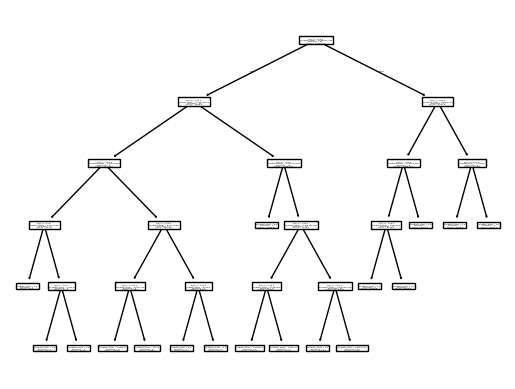

In [11]:
tree.plot_tree(octtree)

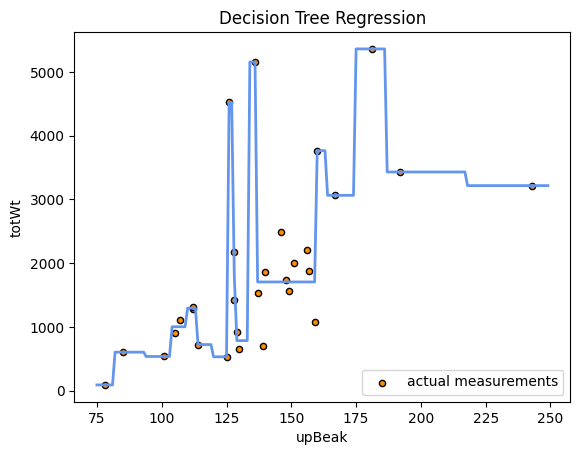

In [12]:
plt.figure()
plt.scatter(X, Y, s=20, edgecolor="black", c="darkorange", label="actual measurements")
plt.plot(X_test, y, color="cornflowerblue", linewidth=2)
plt.xlabel("upBeak")
plt.ylabel("totWt")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

It allowed for more cutoffs to occur before reaching the leaves.

**Task5**:

Was increasing the depth of the tree a good idea for this data set?

Why or why not? Try to use one of "underfitting" or "overfitting" in your answer.

It overfit very hard, so probably not the best.

**Task6:**

Name some pros and cons to using a decision tree. Think about what they do better than other models you've seen, and what they do worse.

Very fast to run
Overfit a lot if not kept in check
Easy to create
Can only do straight right angles, not a curve

### Random Forests (RF) and BART

A randomized decision tree on it's own needs lots of care and direction to make sure it doesn't overfit--but a whole bunch of decision trees with randomized root nodes, added together, police themselves. Any method that combines the results of multiple randomized decision trees is called a Random Forest (RF). RFs turn out to be pretty accurate, and also one of the more interpretable model types, thanks to being built from decision trees. Increasing the number of trees can make RFs very accurate, and RFs can be exceptionally fast to fit if the number of trees isn't too big.

Why is combining trees so much better? If we ensure that there's a diversity of trees (ensure they aren't all making similar decisions), then each tree is picking up on a different pattern in the data. Combining the results of the trees combines all the patterns each tree picked up, resulting in a model that "knows" about all of the patterns and can make better predictions. This is called ensemble learning, where a bunch of weak learners are combined to result in more accurate predictions.

At least, that's what we hope happens. There's no guranttee that each tree will pick up something unique about the data. Luckily, we can ecourage our trees to find different patterns by using a BART model.

Here's how: In addition to the randomized root nodes of a a basic RF, BART builds its trees in a sort of sequential manner. BART actually starts with all the trees it needs, but then randomly alters each tree based on the other trees. The "based on the other trees" bit ensures that BART is encouraging the growth of different trees. This idea is called boosting.

BART goes further though; it selects each change to one of its trees as part of an MCMC. This ensures that the whole BART model is a sample from some posterior distribution of possible random forests. You can find a slightly more in depth summary of the BART model as described [here](https://www.youtube.com/watch?v=xWhPwHZF4c0).

There's a final step also unique to BART, that the video above doesn't really cover: BART puts regularizing priors on the depth of each decision tree, and on the magnitude of the leaf nodes. The priors over the depth helps ensure that all the trees will be shallow, or that the depth will be much less than the number of data points.
Priors on the leaf nodes ensures that our model only explores near the actual data; the leaf node priors are more traditional regularizing priors.



#### Why all the background on how BART works?

BART is a particularly good example of the algorithm buidling process. It started with something that works with many flaws (Decision Trees), imporved to something that works pretty well on its on (RFs), but kept adding things that helped either reduce underfitting (boosting) or reduce overfitting (MCMC, priors). The result is a flexible model that can accurately fit data *and* that we don't have to spend forever tuning.

That push to make a better algorithm happened to create something that approximates a known mathematical object: a BART model with infinite trees is a nowhere differentiable Guassian Process. BART models are often much faster than any type of GP, and *way* easier to use. They are also simple to interpret, b/c their building blocks, decision trees, are easy to interpret.

One last time: people invented a good model by considering how to best balance underfitting, overfitting, speed, and interpretability.

## Implementing BART in PyMC

Armed with knowledge of how BART works and why we should use it, let's build a model with it.

### Octupus BART

First is some preliz stuff I used to come up with a decent likelihood. You don't need to run it, I just thought I'd leave it here so y'all could see a bit of my thought process.

In [13]:
import preliz as pz

(Gamma(alpha=1.9, beta=0.0011), <Axes: >)

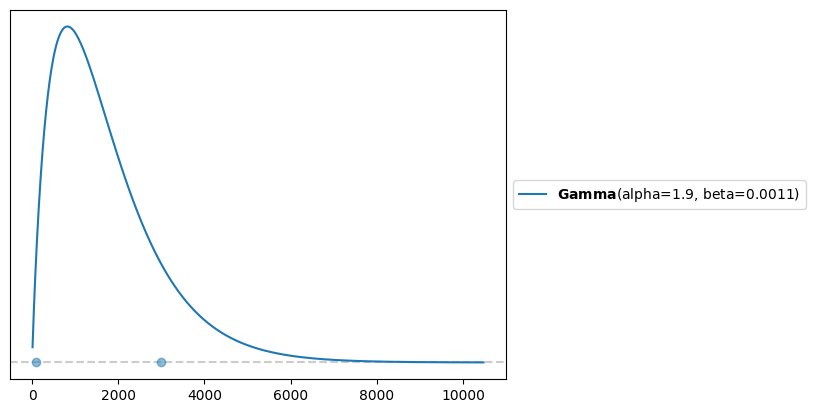

In [14]:
pz.maxent(pz.Gamma(), 100, 3000, 0.85)

<Axes: >

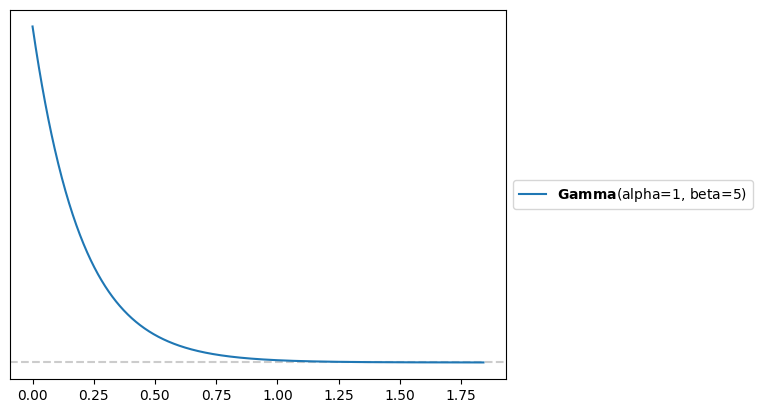

In [15]:
pz.Gamma(1,5).plot_pdf()

We never looked at the actual dataframe, which was bad form. Let's do it now.

(array([4., 7., 5., 5., 2., 2., 2., 0., 1., 2.]),
 array([  91.,  618., 1145., 1672., 2199., 2726., 3253., 3780., 4307.,
        4834., 5361.]),
 <BarContainer object of 10 artists>)

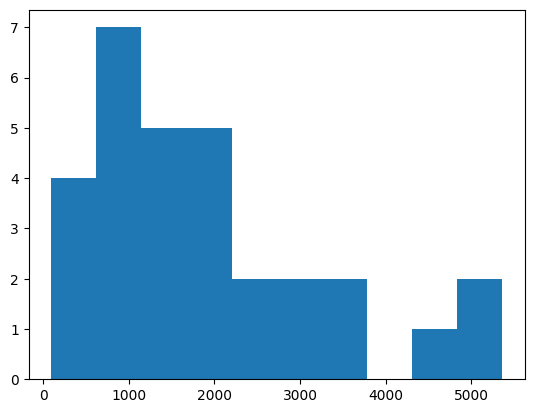

In [16]:
plt.hist(octps.totWt)

In [17]:
octps.head()

,totWt,upBeak,loBeak,latWall
0,91,78,78,74
1,532,125,120,131
2,537,101,92,138
3,605,85,107,135
4,647,130,101,155


The below code is just here to remind you what X and Y are. It also has features commented out; that can be a nice way to put multiple predictiors into a BART model.

In [18]:
#features = ["upBeak", "loBeak", "latWall"]

X = octps["upBeak"].to_numpy().reshape(-1, 1)
Y = octps["totWt"].to_numpy()

**Task7**:

Examine the model below. Is the BART part of the model a prior, or a likelihood?

Were GPs priors, or likelihoods?

In [19]:
with pm.Model() as model_octps:
    s = pm.HalfNormal('s',1000)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y)
    idata_octps = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

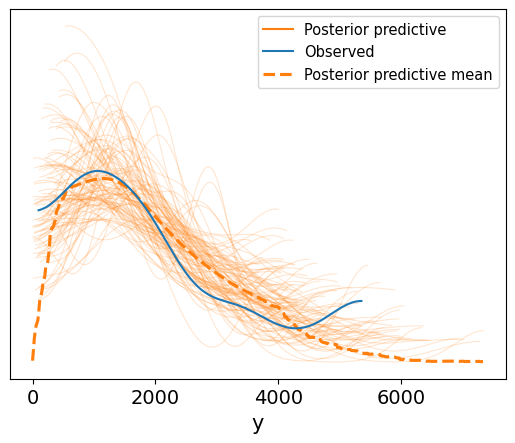

In [20]:
#generate the posterior predictive dist
pm.sample_posterior_predictive(idata_octps,model_octps, extend_inferencedata=True)
az.plot_ppc(idata_octps, num_pp_samples=100, colors=["C1", "C0", "C1"])

In [21]:
posterior_mean = idata_octps.posterior["μ"]

μ_hdi = az.hdi(ary=idata_octps, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_octps, group="posterior_predictive", var_names=["y"]
).T

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


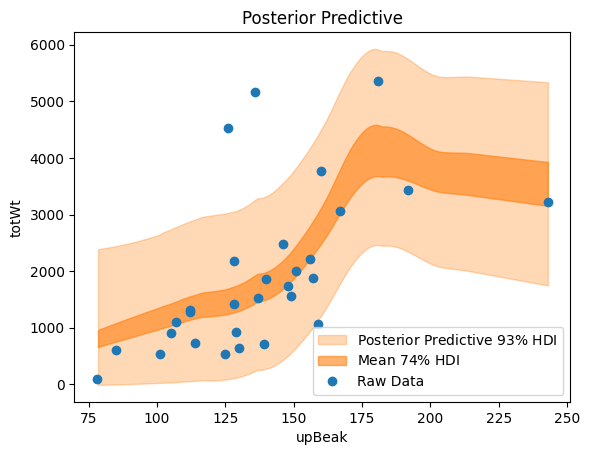

In [22]:
idx = np.argsort(X[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive $93\%$ HDI"},
)

az.plot_hdi(
    x=X[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(octps["upBeak"], octps["totWt"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="upBeak",
    ylabel="totWt",
);

**NOTE**: Because BART models--and random forests in general--are just a bunch of horzontal and vertical lines taped together, they have a bias towards "flatness" (or parallelness to the predictor) on the left and right edges of any predictive plot.

**Task8**:

Comment on the fit of the above posterior predictive check. Is it good, bad, or ugly?

# Counties Data, PDPs, ICE, and VI plots

Trigger warning: This analysis covers suicide, and it attempts to find things that influence suicide rates by county in the USA. If you need support in dealing with this topic, reach out. Your voice matters!

You can find a full explanation of the counties dataset [here](https://github.com/evangambit/JsonOfCounties?tab=readme-ov-file). The person who curated and intially cleaned the data (Evan Gambit?), did great work, and made this analysis possible. I do not know them, but I am grateful.

I've clean the data to make it more amenable to analyze suicide and poverty, and then I use a BART to model predict suicide rate using teen birth rate, poverty rate, self reported number of mentally unhealthy days, proportion with less than a high school level education, and the proportion that voted for the GOP in the 2020 election.

We will make use of some new tools, called partial dependence plots (pdp) and individual conditional expectation (ice) plots, to determine which variables are associated with a higher suicide rate by county.

Pdps will allow us to see how each predictor variable relates to suicide rate--assuming there are no interactions between predictor variables.

Ice plots will allows to see if their are interactions, and even give us a hint as to the nature of the interactions.

Vi plots will give us an idea of which variables contribute more predictive power.

Altogether, the plots will give us a clearer picture of what our model is, what it values, and what relationships exist in the data.

## Data and Exploratory Data Analysis

First though, is a bit of data cleaning. Not all the columns seem relevant to predict suicide; I arbitrarily chose the variables below.

Someone could easily decide a different set are relevant, and end up with a different analysis than me.

In [23]:
counties = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/counties.csv')

In [24]:
clmn_list = ['name',
             'state',
             'population/2019',
             'health/Violent Crime Rate',
             'life-expectancy',
             'health/Teen Birth Rate',
             'poverty-rate',
             'health/Average Number of Mentally Unhealthy Days',
             'health/% Excessive Drinking',
             'edu/bachelors+',
             'avg_income',
             'deaths/suicides',
             'edu/less-than-high-school',
             'elections/2020/gop',
             ]
sad_stats =  counties.loc[:,clmn_list]

I also drop any rows that don't have data for any one of the variables. This removed around 300 to 400 hundred counties. Perhaps having data for those counties would alter the ensuing results?

I won't attempt to answer that question for two reasons:
- creating a model for the missing data would require me to learn about every county that we dropped, and/or learning about the data collection method, which I don't have time for.
- We have a large enough set of data that we can still learn something about the world.

In [25]:
sdsts_nona = sad_stats.dropna()

I next weight the raw counts by county population. This is not representative of proportion of population (its unclear how deaths by suicide influnce the offical poulation count, for example), but it does allow me to compare large counties to small counties. Unlike with raw counts.

In [26]:
sdsts_nona.insert(sdsts_nona.shape[1], "suicide/pop", sdsts_nona['deaths/suicides']/sdsts_nona['population/2019'])
sdsts_nona.insert(sdsts_nona.shape[1], "<hs/pop", sdsts_nona['edu/less-than-high-school']/sdsts_nona['population/2019'])
sdsts_nona.insert(sdsts_nona.shape[1], "gop/pop", sdsts_nona['elections/2020/gop']/sdsts_nona['population/2019'])
sdsts_nona.insert(sdsts_nona.shape[1], "bachelors+/pop", sdsts_nona['edu/bachelors+']/sdsts_nona['population/2019'])
sdsts_nona.drop(['deaths/suicides', 'edu/less-than-high-school','elections/2020/gop','edu/bachelors+'], axis=1, inplace=True)

<ipython-input-26-9efc0599665b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdsts_nona.drop(['deaths/suicides', 'edu/less-than-high-school','elections/2020/gop','edu/bachelors+'], axis=1, inplace=True)


In [27]:
#this column name is too dang long, so I shorten it
sdsts_nona.rename(columns={'health/Average Number of Mentally Unhealthy Days':'mentUnhealth','health/Teen Birth Rate':'teenBirth'}, inplace=True)

<ipython-input-27-490a769b70f1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdsts_nona.rename(columns={'health/Average Number of Mentally Unhealthy Days':'mentUnhealth','health/Teen Birth Rate':'teenBirth'}, inplace=True)


Finally, I did some exploratory data analyisi to see which variables might actually be associated with suicide rate. I didn't keep all my plots from that, but here's a sample of some I thought were interesting.

In [28]:
sdsts_nona.head()

,name,state,population/2019,health/Violent Crime Rate,life-expectancy,teenBirth,poverty-rate,mentUnhealth,health/% Excessive Drinking,avg_income,suicide/pop,<hs/pop,gop/pop,bachelors+/pop
0,cuming county,NE,8846,22.125118,81.20,12.695312,8.9,3.477194,25.110453,58610,0.000054,0.001311,0.396450,0.002690
1,lancaster county,NE,319090,325.955385,80.46,14.323427,10.7,3.826857,25.446613,49889,0.000105,0.000020,0.219662,0.000124
3,keith county,NE,8034,105.741121,79.24,23.427041,11.1,3.773762,24.073685,45896,0.000172,0.001058,0.441125,0.002552
4,phelps county,NE,9034,97.097853,79.86,16.500000,10.0,3.729252,23.178963,52792,0.000121,0.000742,0.460151,0.002601
5,webster county,NE,3487,110.420980,78.78,15.325670,12.3,3.673882,22.241705,48607,0.000232,0.001778,0.433324,0.006596


<Axes: xlabel='poverty-rate', ylabel='suicide/pop'>

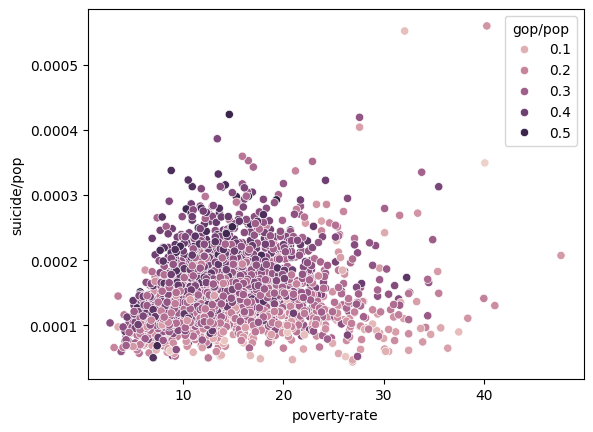

In [29]:
sns.scatterplot(data = sdsts_nona, y = 'suicide/pop', x = 'poverty-rate', hue = 'gop/pop')

<Axes: xlabel='gop/pop', ylabel='suicide/pop'>

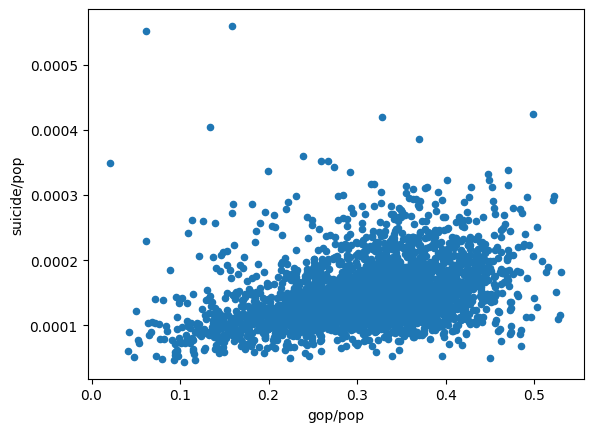

In [30]:
sdsts_nona.plot(y = 'suicide/pop', x = 'gop/pop', kind = "scatter")

### Prep Data for BART Model

After the exploratory data analysis, I only used teen birth rate, poverty rate, number of mentally unhealthy days, proportion with less than a highschool education, and proportion who voted for the GOP in the 2020 election.

In [31]:
#I combine all my predictor variables into one dataframe
X = sdsts_nona[[
             'teenBirth',
             'poverty-rate',
             'mentUnhealth',
             '<hs/pop',
             'gop/pop',
             ]]
Y = sdsts_nona['suicide/pop'].to_numpy()

## BART Model

Here's the model, in a svelte six lines of code.

Suicide rate is again all positive (like octupus beak weight), so I use a gamma likelihood. There are also the same log and exp shenanigans from before; these serve to make suicide rate go into the negatives, b/c BART is a real numbers 4eva type of gal.

But seriously, the pymc implementation of BART needs to have its predicted range over positive and negative values, so we have to do this for any all positive support likelihood.

In [32]:
with pm.Model() as model_counties:
    s = pm.HalfNormal('s',20) #sigma = 20 is a blind guess
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y) #likelihood
    idata_counties = pm.sample(compute_convergence_checks=False)

Output()

In [33]:
pm.sample_posterior_predictive(idata_counties,model_counties, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Some of y'all may look at this and think "inverse gamma would definitely be better" but every time I tried that likelihood, if gave me strange behavior. Maybe you'll have better luck if you try.

(0.0, 0.0005)

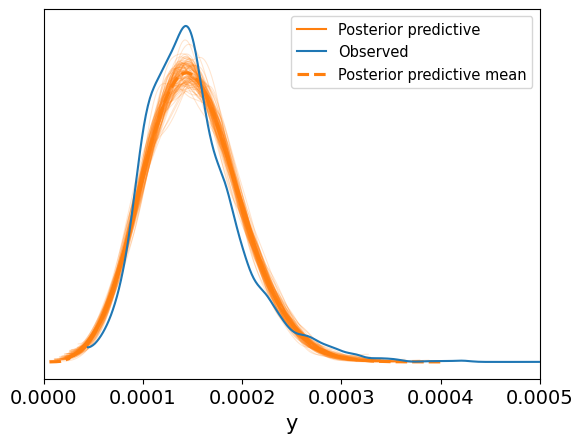

In [34]:
ax = az.plot_ppc(idata_counties, num_pp_samples=100, colors=["C1", "C0", "C1"])
ax.set_xlim(0.0,0.0005)

The next two code blocks let you plot the posterior predictive for a single one of the variables versus suicide rate. This is less useful, in my opinion, than what follows.

In [35]:
posterior_mean = idata_counties.posterior["μ"]

μ_hdi = az.hdi(ary=idata_counties, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_counties, group="posterior_predictive", var_names=["y"]
).T

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


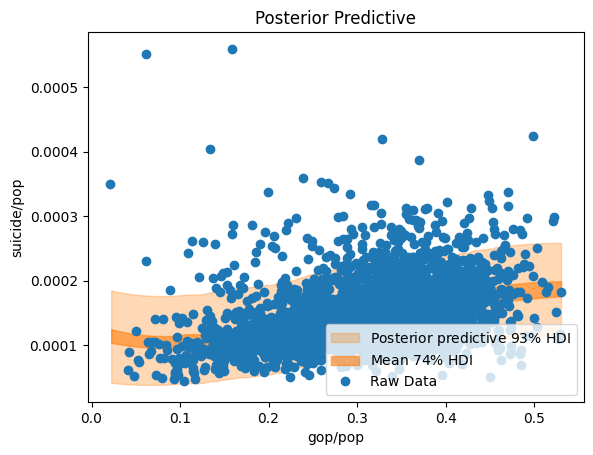

In [36]:
idx = np.argsort(X.to_numpy()[:, 4]) #grab fifth row
fig, ax = plt.subplots()

az.plot_hdi(
    x=X.to_numpy()[:, 4],#grab fifth row
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior predictive $93\%$ HDI"},
)

az.plot_hdi(
    x=X.to_numpy()[:, 4],#grab fifth row
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(sdsts_nona['gop/pop'], sdsts_nona["suicide/pop"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="gop/pop",
    ylabel="suicide/pop",
);

### Partial Dependence Plots (pdp)

This is the beginning of the exciting stuff.

The five graphs below show the association between a predictor varible and the predicted variable, marginalized over the other variables.

Why is that exciting?

It means that these plots show the affect of the proportion who voted for the GOP in 2020 conditioning on the effect of poverty, teen birth rate, reported mental health, and under-education...

...**ASSUMING** that all those predictor variables are mostly independent.

array([<Axes: xlabel='teenBirth'>, <Axes: xlabel='poverty-rate'>,
       <Axes: xlabel='mentUnhealth'>, <Axes: xlabel='<hs/pop'>,
       <Axes: xlabel='gop/pop'>], dtype=object)

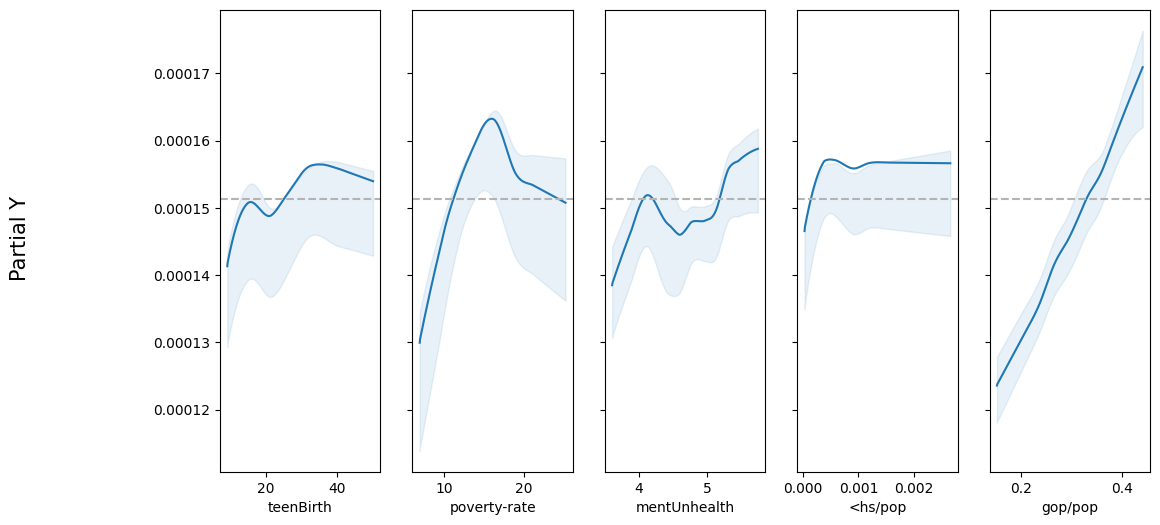

In [37]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

**Task10**:

Interpret the gop/pop versus suicide rate partial dependence plot, assuming approximate independence between the predictor variables.

 What is the trend?

 Why?

### Individual Conditional Expectation (ice) Plots

Let's drop the assumption that each of the predictor variables is predictor variables is indepentent--b/c they aren't.

For example, education level and GOP voting tendency have had a pretty stable negative association in last couple of decades. And poverty, teen birth rate, education, and mental health are all likely interacting with each other as well.

The first step to account for that is an ice plot.

Look at the lines that make up the ice plots below. The average of all those lines makes up the pdp from above; each line n the ice plot represents a single observation. All those lines averaged are teh pdp.

Individual predictions per data point help us see trends that aren't present in the average.

What do we look for? Parallel-ness: if all the lines in each plot are parallel, then when can ignore the ice plot, and go back to the pdp

array([<Axes: xlabel='teenBirth'>, <Axes: xlabel='poverty-rate'>,
       <Axes: xlabel='mentUnhealth'>, <Axes: xlabel='<hs/pop'>,
       <Axes: xlabel='gop/pop'>], dtype=object)

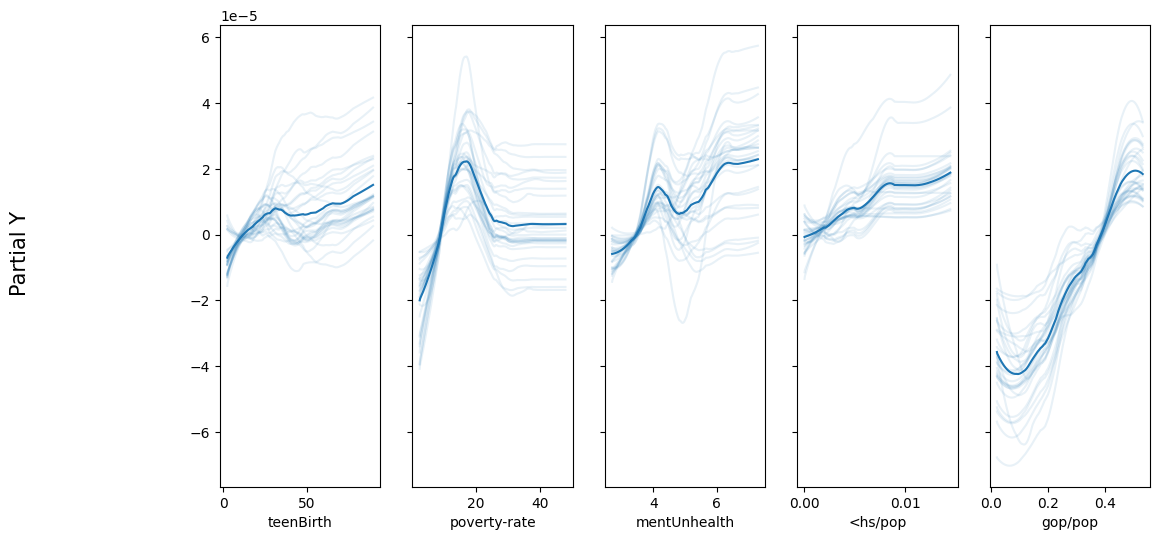

In [38]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

**Task 11**:

Are the lines within each plot parallel, in the ice plots above?

If they aren't parallel, then describe and interpret the areas in which the lines within the plots are not parallel.

Hint: The lines aren't parallel. Get to describing and interpreting.

### Variable Importance (vi) Plots

VI plots, in theory, are supposed to tell us which variables to select if all we care about is prediction accruacy and speed.

For example, the plot below seems to indicate we could probably drop teen birth rate and number of bad mental health days, and get a similar level of performance. It also seems to indicate that gop tendancy and poverty rate give the biggest boosts in performance, as there jumps up in $R^{2}$ are largest.

There are lots of caveats to those interpretations though.

- The order in which the model calculated the $R^{2}$ values matters--and the order is not staable (i.e. it's different from run to run)
- we're using $R^{2}$ instead of elpd_loo, b/c pymc hasn't implemented elpd_loo for BART.
- this plot does not show us variable interactions. BART is almost certainly applying the equivalent of variable interactions, but our only hint about what those interactions are comes from the ice plots above

In [39]:
vi_counties = pmb.compute_variable_importance(idata_counties, μ_, X)

<Axes: ylabel='R²'>

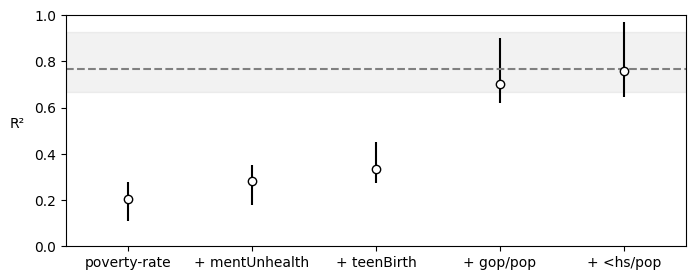

In [40]:
pmb.plot_variable_importance(vi_counties)

### Conclusion to predicting sucicide rate by county using BART



**Task12**:

Summarize everything we learned from and about model_counties.

# Summary

Once again, we've covered a lot of ground.

We put in the work to start understanding the concept of decision trees, how they can flexibly adapt to data, in an interpretable way.

Then we jumped into a theoretical disscussion on how to supe up our decions trees, making them more powerful.

Those fancy, aggregated decision trees were called BART, and they allowed us to quickly create a model which could determine an appropriate non-linear shape, all on its own.

Next, we pivoted to a different application of BART, with multiple predictiors. It still helped to have BART be able to capture non-linear trends, but we also used pdps, ice plots, and vi plots to find out the relationships between several predictor variables and suicide rate by county.

We were able to determine some interesting associations, and also learn that there were many interactions between our predictor variables.

BART is a powerful, flexible, and interpretable model. We can use the framework to quickly create a good prediction engine for simple to complex data. We can also use it to learn about relationships in our data.

### What's next?

So, is there anything BART (or random forests) can't do?

BART and RFs can do almost anything a GP can do, which is a lot. But there are a couple model types that are doing something different than GPs. Some of those are the unspervised learning methods--mostly PCA and UMAP. The other is a big buzz word: deep neural networks (DNN). The next two units will tackle rudimentary NNs, and then DNNs, and we'll probably get lost along the way. But who knows, maybe it'll be fun too.